# **Fe XIII density ratio look-up table generator**

This notebook helps create a forward-modelled lookup table of Fe XIII 1074.7nm and 1079.8nm line ratios used to compute densities at various heights in the offlimb corona.


Calculations done using the [CHIANTI 11.0](https://www.chiantidatabase.org/chianti_download.html) database and [PyCELP](https://github.com/tschad/pycelp) commit 7f72443.

If using these scripts, please consider referencing [PyCELP](https://ui.adsabs.harvard.edu/abs/2020SoPh..295...98S/abstract), [CHIANTI](https://www.chiantidatabase.org/referencing.html),  and [CLEDB](https://ui.adsabs.harvard.edu/abs/2022SoPh..297...63P/abstract) publications.

The table is computed using all levels for the Fe XIII atom available via CHIANTI. 

Contact: Alin Paraschiv, NSO ---- arparaschiv at nso edu

Last updated: 2025 Apr. 14

<div class="alert alert-warning" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Note:</strong> Users should not by default compute the look-up table using this notebook. Redoing these calculations is only needed when a significant PyCELP or CHIANTI database update exists.
        </div>   
    </div> 
</div>

In [1]:
import pycelp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
%matplotlib widget
import os
import pickle
import time
from tqdm import tqdm
os.environ["XUVTOP"] = './config/CHIANTI_11.0_database/' ## If you havent already set the environment variable XUVTOP for the location of the database, set it here


In [2]:
la   = 50          ### Number of levels to include when doing the statistical equiblibrium and radiative transfer equations. The database has ~750 levels. Anything above 400 levels shoudl be enough.
fe13 = pycelp.Ion('fe_13',nlevels = la)
## some useful prints of the Ion parameters extracted from the database
#print("\n",fe13,"\n")                ## show extracted ion spacifications
#fe13.show_lines(15)                  ## show 15 transitions from the Fe XIII atom.

 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.elvlc
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.wgfa
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.scups
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.psplups
 using default abundances: ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 reading:  ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 testing default file: ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 reading:  ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors


In [3]:
## Constants with respect to this specific caltulation
electron_temperature = fe13.get_maxtemp()  ## kelvins; maximum formation temperature for Fe XIII. We will ado all calculations under this assumption. This implies we are approximating density only corresponding to plasma around this temperature.
thetaBlocal          = 0.                  ## degrees; magnetic orientation. Value set to radial. Density sensitivity to this parameters is very low. This sensitivity will manifest at values orders of magnitude lower than the resolution space of the look-up table. 

In [4]:
### arrays to store results
## The grid space defined here allows sampling 10 density values oper order of density magnitude with line ratios sensible to significant measurements of two decimals.

densities   = np.round(10.**np.linspace(6.,12,120),3)    ## array of densities to be probed. This gives roughly 10 density samples for each order of magnitude in the logarithmic density space spanning 10^6-10^12 electrons. 
height      = np.round(np.linspace(0.01,1.00,99) ,2)     ## solar radius units above the photosphere (add +1 to measure from disk center). This corresponds to offlimb heights of 1-2 solar radius, with intervals of 0.01
intensities = np.zeros((2,len(height),len(densities)))   ## to store both Fe XIII lines.
#alignments  = np.zeros((2],len(height),len(densities)))  ## we don't really need these for this calculations, but interesting avenues open if exploring

for h,eheight in enumerate(tqdm(height)):
    for d,edens in enumerate(densities):
        fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
        ln1 = fe13.get_emissionLine(10747.)
        ln2 = fe13.get_emissionLine(10789.)
        intensities[0,h,d] = ln1.calc_Iemiss()[0]
        intensities[1,h,d] = ln2.calc_Iemiss()[0]
        #alignments[0,h,d]  = ln1.upper_level_alignment
        #alignments[1,h,d]  = ln2.upper_level_alignment

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [04:10<00:00,  2.53s/it]


**Note:** More information on using the PyCELP Ion class can be found in the [dedicated example notebook](https://github.com/tschad/pycelp/blob/main/examples/A_tour_of_the_Ion_class.ipynb) found in the PyCELP repository.

In [5]:
#height above the photosphere variable
##CLEDB uses sun center references, so heights need to add 1 solar radius to account for the region up to the photosphere.
heights = height + 1 ## Sun center reference coordinate system.
print(heights.shape)
print(heights)

(99,)
[1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14
 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28
 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42
 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.52 1.53 1.54 1.55 1.56 1.57
 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68 1.69 1.7  1.71
 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82 1.83 1.84 1.85
 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96 1.97 1.98 1.99
 2.  ]


In [9]:
## density range of 10^6 - 10^12 electrons that is sampled with about 20 sample values per order of magnitude
print(densities.shape)
print(np.round(np.log10(densities),2))

(120,)
[ 6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.61  6.66  6.71  6.76  6.81  6.86  6.91  6.96  7.01  7.06  7.11  7.16
  7.21  7.26  7.31  7.36  7.41  7.46  7.51  7.56  7.61  7.66  7.71  7.76
  7.82  7.87  7.92  7.97  8.02  8.07  8.12  8.17  8.22  8.27  8.32  8.37
  8.42  8.47  8.52  8.57  8.62  8.67  8.72  8.77  8.82  8.87  8.92  8.97
  9.03  9.08  9.13  9.18  9.23  9.28  9.33  9.38  9.43  9.48  9.53  9.58
  9.63  9.68  9.73  9.78  9.83  9.88  9.93  9.98 10.03 10.08 10.13 10.18
 10.24 10.29 10.34 10.39 10.44 10.49 10.54 10.59 10.64 10.69 10.74 10.79
 10.84 10.89 10.94 10.99 11.04 11.09 11.14 11.19 11.24 11.29 11.34 11.39
 11.45 11.5  11.55 11.6  11.65 11.7  11.75 11.8  11.85 11.9  11.95 12.  ]


In [6]:
## compute the line ratios to be used as a height dependent look-up table with respect to the density grid spacing.
##
ratios = intensities[0,:,:] / intensities[1,:,:]
print(ratios.shape)

(99, 120)


In [7]:
## Save the look-up table as a compressed
#np.savez_compressed('./chianti_v'+pycelp.chianti.getChiantiDir()[1]+'_pycelp_fe13_h99_d120_ratio.npz',h=heights,den=densities,rat=ratios)

# Auxiliary code and plots to better understand the look-up table

Plot the results with respect to height:

Text(0, 0.5, 'Ratio [relative line photon units]')

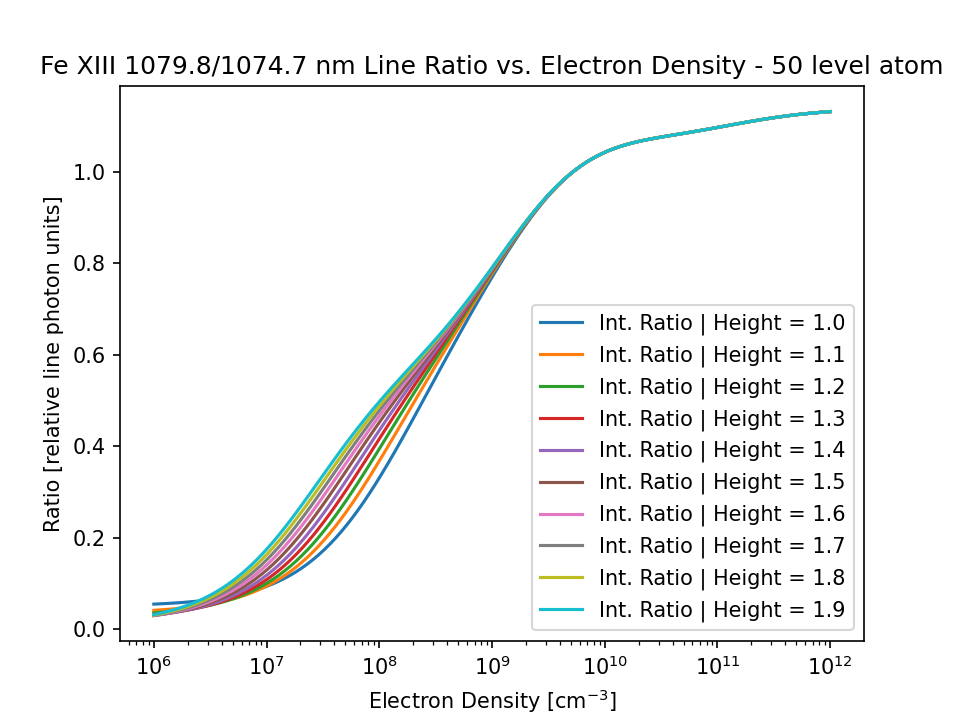

In [8]:
plt.figure()
for i in range(10):
    plt.plot(densities,1/ratios[10*i,:]  ,label = r'Int. Ratio | Height = '+str(np.round(heights[10*i],1))[:4])  ## do one in 10 heights to not overcrowd the plot
plt.legend()
plt.xscale('log')
plt.xlabel('Electron Density [cm$^{-3}$]')
plt.title('Fe XIII 1079.8/1074.7 nm Line Ratio vs. Electron Density - '+str(la)+' level atom')
plt.ylabel('Ratio [relative line photon units]')

Estimate how detailed the atomic calculations need to be to ensure variation is under $10^{-2}$ in line ratios.

In [10]:
for d,dd in enumerate(range(5,500,5)):
    fe13 = pycelp.Ion('fe_13',nlevels = dd)
    fe13.calc_rho_sym(densities[10],electron_temperature, 0.1, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,6] = ln1.calc_Iemiss()[0]
    intensities[1,d,6] = ln2.calc_Iemiss()[0]



 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.elvlc
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.wgfa
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.scups
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.psplups
 using default abundances: ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 reading:  ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 testing default file: ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 reading:  ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.elvlc
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.wgfa
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.scups
 reading:  ./config/CHI

Text(0, 0.5, 'Ratio [relative line photon units]')

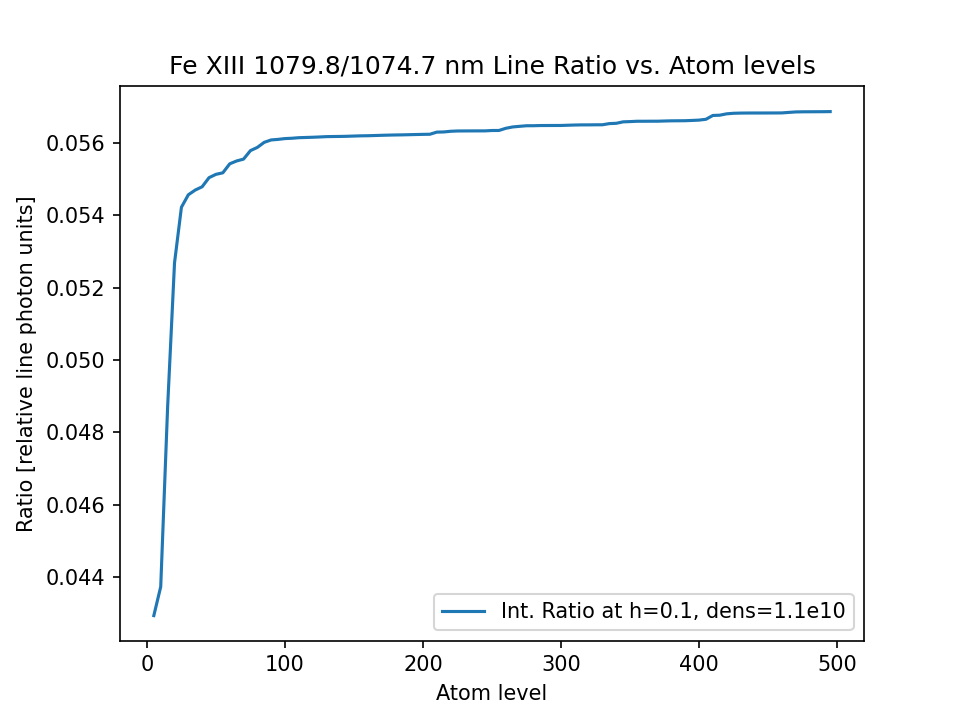

In [11]:
plt.figure()
plt.plot(range(5,500,5),intensities[1,:,6] / intensities[0,:,6]  ,label = r'Int. Ratio at h=0.1, dens=1.1e10')
plt.legend()
plt.xlabel('Atom level')
plt.title('Fe XIII 1079.8/1074.7 nm Line Ratio vs. Atom levels')
plt.ylabel('Ratio [relative line photon units]')
#plt.xscale("log")

#### From this plot, 300 levels appears a good middleground for calculation complexity.

In [12]:
### plot multiple curves
densities   = 10.**np.linspace(6.,12,120)     ## array of densities to be probed. This gives roughly 10 density samples for each order of magnitude in the logarithmic density space spanning 10^6-10^12 electrons. 
eheight      = 0.05#np.linspace(0.01,1.00,99)       ## solar radius units above the limb/photosphere. This corresponds to offlimb heights of 1-2 solar radius, with intervals of 0.01
intensities = np.zeros((2,len(densities),len(height)))

fe13 = pycelp.Ion('fe_13',nlevels = 6)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,0] = ln1.calc_Iemiss()[0]
    intensities[1,d,0] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 20)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,1] = ln1.calc_Iemiss()[0]
    intensities[1,d,1] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 50)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,2] = ln1.calc_Iemiss()[0]
    intensities[1,d,2] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 200)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,3] = ln1.calc_Iemiss()[0]
    intensities[1,d,3] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 400)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,4] = ln1.calc_Iemiss()[0]
    intensities[1,d,4] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 700)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,5] = ln1.calc_Iemiss()[0]
    intensities[1,d,5] = ln2.calc_Iemiss()[0]

fe13 = pycelp.Ion('fe_13',nlevels = 1000)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,6] = ln1.calc_Iemiss()[0]
    intensities[1,d,6] = ln2.calc_Iemiss()[0]

 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.elvlc
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.wgfa
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.scups
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.psplups
 using default abundances: ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 reading:  ./config/CHIANTI_11.0_database/abundance/sun_photospheric_2021_asplund.abund
 testing default file: ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 reading:  ./config/CHIANTI_11.0_database/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.elvlc
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.wgfa
 reading:  ./config/CHIANTI_11.0_database/fe/fe_13/fe_13.scups
 reading:  ./config/CHI

In [51]:
eheight      = 1.05#
fe13 = pycelp.Ion('fe_13',nlevels = 200)
for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,electron_temperature,eheight, thetaBlocal, include_limbdark=True, include_protons=True)
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10789.)
    intensities[0,d,7] = ln1.calc_Iemiss()[0]
    intensities[1,d,7] = ln2.calc_Iemiss()[0]
    intensities[0,d,8] = ln1.calc_PolEmissCoeff(1,thetaBLOSdeg=43,azimuthBLOSdeg=35)[0]
    intensities[1,d,8] = ln2.calc_PolEmissCoeff(1,thetaBLOSdeg=43,azimuthBLOSdeg=35)[0]

 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/fe/fe_13/fe_13.elvlc
 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/fe/fe_13/fe_13.wgfa
 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/fe/fe_13/fe_13.scups
 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/fe/fe_13/fe_13.psplups
 using default abundances: /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/abundance/sun_photospheric_2021_asplund.abund
 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/abundance/sun_photospheric_2021_asplund.abund
 testing default file: /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/ioneq/chianti.ioneq
 reading:  /home/noxpara/Documents/physics_progs/CHIANTI_10.1_database/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole ra

In [52]:
print( ln1.calc_Iemiss() )
print(ln1.calc_PolEmissCoeff(1,thetaBLOSdeg=1,azimuthBLOSdeg=5))

(4.429965045397634e-05, 'photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$')
(4.429965338107397e-05, 1.3176165096080777e-15, -2.3233134087081845e-16, -3.583909834863003e-09)


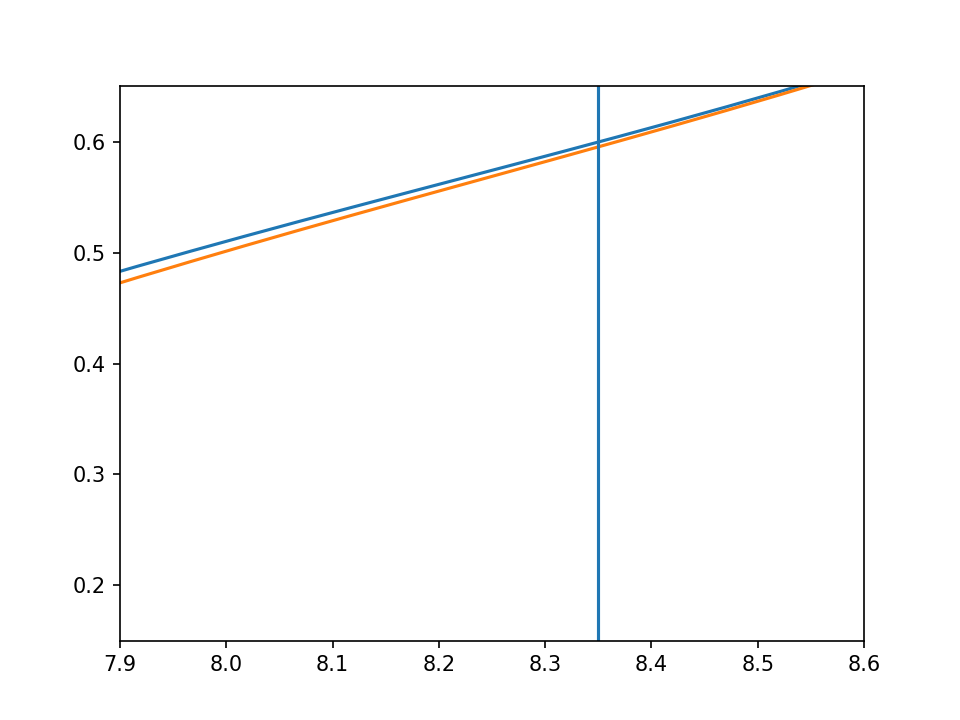

In [54]:
plt.figure()

densities1=np.log10(densities)

plt.plot(densities1,intensities[1,:,7] / intensities[0,:,7]  ,label = r'Int. Ratio | 50 level')
plt.plot(densities1,intensities[1,:,8] / intensities[0,:,8]  ,label = r'Int. Ratio | 50 level')
plt.xlim(7.9,8.6)
plt.ylim(0.15,0.65)
plt.axvline(8.35)

Text(0, 0.5, 'Ratio [relative line photon units]')

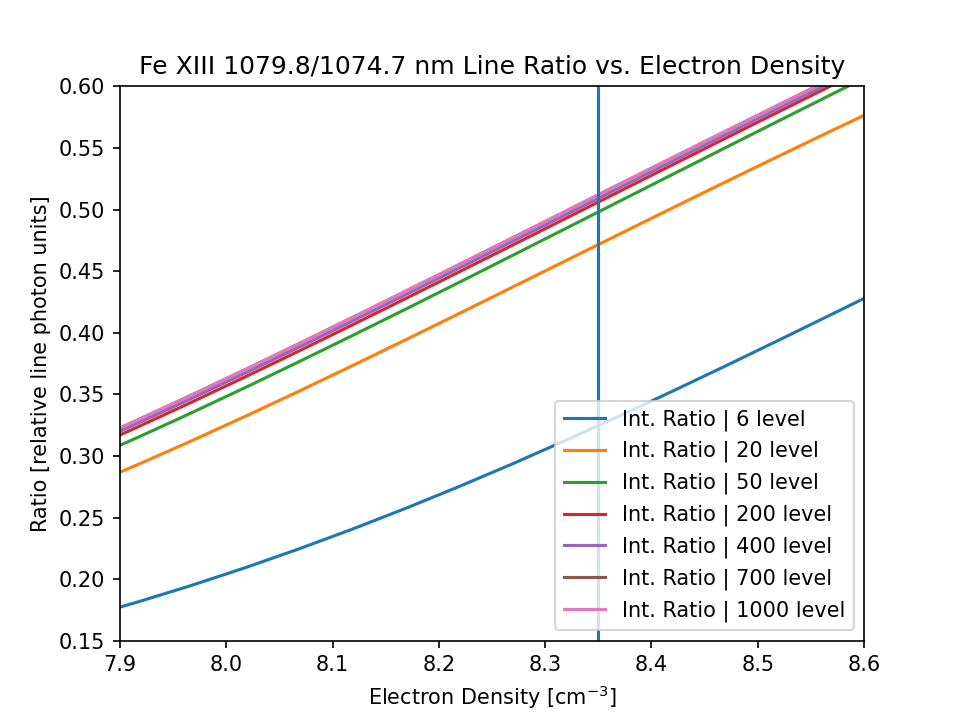

In [24]:
plt.figure()

densities1=np.log10(densities)

plt.plot(densities1,intensities[1,:,0] / intensities[0,:,0]  ,label = r'Int. Ratio | 6 level')
plt.plot(densities1,intensities[1,:,1] / intensities[0,:,1]  ,label = r'Int. Ratio | 20 level')
plt.plot(densities1,intensities[1,:,2] / intensities[0,:,2]  ,label = r'Int. Ratio | 50 level')
plt.plot(densities1,intensities[1,:,3] / intensities[0,:,3]  ,label = r'Int. Ratio | 200 level')
plt.plot(densities1,intensities[1,:,4] / intensities[0,:,4]  ,label = r'Int. Ratio | 400 level')
plt.plot(densities1,intensities[1,:,5] / intensities[0,:,5]  ,label = r'Int. Ratio | 700 level')
plt.plot(densities1,intensities[1,:,6] / intensities[0,:,6]  ,label = r'Int. Ratio | 1000 level')
plt.legend()
#plt.xscale('log')
plt.xlim(7.9,8.6)
plt.ylim(0.15,0.6)
plt.axvline(8.35)
plt.xlabel('Electron Density [cm$^{-3}$]')
plt.title('Fe XIII 1079.8/1074.7 nm Line Ratio vs. Electron Density')
plt.ylabel('Ratio [relative line photon units]')

Compare with the older/deprecated idl look-up table:

In [16]:
from scipy.io import readsav    ## in DKIST_DENS
## theoretical chianti ratio calculations created via IDL        
    ## read the IDL (for now) chianti table         
chia = readsav("./chianti_v10.0_sswidl_fe13_h50_d33_ratio.sav")      ## variable directly readable by work_1pix
    #print(chianti_table.keys())               ## Debug - check the arrays
    
    ##  in the save file, 'h' is an array of heights in solar radii (from 1.00 to 1.50); 
    ##  'den' is an array of density (from 5.0 to 13.0), 'rat' is a 2D array containing line ratios corresponding to different density values at different heights.
    ##  To query the database of heights:
print(chia['h'],chia['h'].shape,chia['rat'].shape,chia['den'].shape)


[1.        1.01      1.02      1.03      1.04      1.05      1.06
 1.07      1.08      1.09      1.1       1.11      1.12      1.13
 1.14      1.15      1.16      1.17      1.18      1.19      1.2
 1.21      1.22      1.23      1.24      1.25      1.26      1.27
 1.28      1.29      1.3       1.31      1.3199999 1.3299999 1.34
 1.35      1.36      1.37      1.38      1.39      1.4       1.41
 1.42      1.43      1.44      1.45      1.46      1.47      1.48
 1.49     ] (50,) (50, 33) (50, 33)


In [17]:
chia['h'][25]
heights[25]

1.26

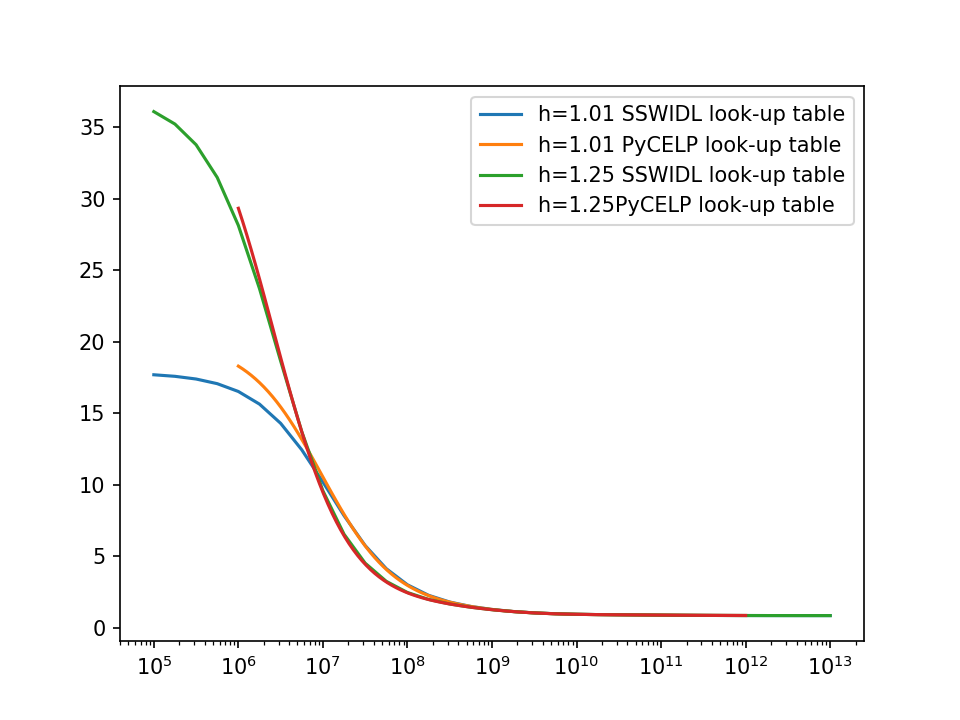

In [18]:
plt.figure()
plt.plot(chia.den[1,:],chia.rat[1],label="h=1.01 SSWIDL look-up table")
plt.plot(densities,ratios[0,:],label="h=1.01 PyCELP look-up table")
plt.plot(chia.den[25,:],chia.rat[25],label="h=1.25 SSWIDL look-up table")
plt.plot(densities,ratios[24,:],label="h=1.25PyCELP look-up table")
plt.xscale('log')
plt.legend()

We see that the idl calculation does not 1:1 match the higher accuracy pycelp calculation